In [ ]:
import sys
sys.path.append("../../..")

from datetime import date
import pandas as pd
import plotly.graph_objects as go
import numpy as np
import rasterio as rio
import rioxarray as rxr
import shap

from modules import processing_module as processing
from modules import interpolation_module as interp
from modules import ai_module_extended as ai

In [3]:
def load_model(pollutant, training_mode, prefix):
    train_path = f'../harmonia_processor/{pollutant}/train/training_{training_mode}.csv'
    training_dataset = importer.import_df(train_path, date_format='%Y-%m-%d')
    training_dataset = training_dataset.dropna()
    training_dates = training_dataset.copy()[['date']]
    if 'date' in list(training_dataset.columns):
        training_dataset = training_dataset.drop(['date'], axis=1)

    test_path = f'../harmonia_processor/{pollutant}/train/validation_{training_mode}.csv'
    testing_dataset = importer.import_df(test_path, date_format='%Y-%m-%d')
    testing_dataset = testing_dataset.dropna()
    testing_dates = testing_dataset.copy()[['date']]
    if 'date' in list(testing_dataset.columns):
        testing_dataset = testing_dataset.drop(['date'], axis=1)

    #save the training columns for selecting them in the prediction dataset
    training_columns = list(training_dataset.columns)
    training_columns.remove('exc')

    model_path = f'../harmonia_processor/{pollutant}/model/{prefix}_model_{training_mode}.csv'
    ai_model = ai.MLProcessor(training_dataset.copy(), testing_dataset.copy())
    ai_model.load_model(model_path)
    ai_model.model_type = prefix
    return ai_model

In [4]:
model_options = {
    'RF': {
        "prefix": 'rf',
        "training_options": {
            "normalized": False,
            "n_estimators": 500,
            "n_jobs": -1,
            "max_depth": 30,
            "random_state": None
        },
        "prediction_options": {
            "normalized": False
        }
    },
    
    'SVM': {
        "prefix": 'svm',
        "training_options": {
            "normalized": True,
            "kernel": 'rbf',
            "probability": True,
            "verbose": False,
            "max_iter": 10,
            "random_state": None,
            "cache_size": 1024,
            "n_jobs": 5
        },
        "prediction_options":{
            "normalized": True,
        }
    },
    
    'LSTM': {
        "prefix": 'lstm',
        "training_options": {
            "normalized": True,
            "activation": 'sigmoid',
            "metrics": ['accuracy'],
            "optimizer": 'adam',
            "loss": 'binary_crossentropy'
        },
        "prediction_options":{
            "normalized": True,
        }
    },
    'XGBoost': {
        "prefix": 'xgb',
        "training_options": {
            "normalized": True,
            "activation": 'sigmoid',
            "metrics": ['accuracy'],
            "optimizer": 'adam',
            "loss": 'binary_crossentropy'
        },
        "prediction_options":{
            "normalized": True,
        }
    }
}


In [5]:
pollutant_data = {
    'pm10': {
        "threshold": 45 #daily in regulation: CORRECT
    }, 
    'pm25': {
        "threshold": 25 #daily not in regulation: Estimated using the EU yearly + AQI Poor limit 
    }, 
    'no2': {
        "threshold": 50 #daily not in regulation: Estimated using the EU yearly and hourly limits + AQI Poor limit 
    }, 
    'so2': {
        "threshold": 50 #daily in regulation: CORRECT
    }, 
    'o3': {
        "threshold": 120 #8-hour mean in regulation: NO CORRECT
    }, 
}

In [31]:
importer = processing.HarmoniaProcessor()
#pollutants = ['pm10', 'pm25', 'no2', 'so2', 'o3']
pollutants = ['o3']
#Missing no2 because there are not exceedances
#models = ['LSTM','RF','SVM','XGBoost']
models = ['XGBoost']
train_modes = ['rand_NObalance']
'''
train_modes = [
    'rand_balance',
    'NOrand_balance',
    'rand_NObalance',
    'NOrand_NObalance'
]
'''

"\ntrain_modes = [\n    'rand_balance',\n    'NOrand_balance',\n    'rand_NObalance',\n    'NOrand_NObalance'\n]\n"

In [32]:
#Score the models
scores_df_columns = ["type", "train_mode", "pollutant", "prefix", 'MAE', 'MSE', 'RMSE', 'R2']
scores_df = pd.DataFrame(columns=scores_df_columns)

for model_to_use in models:
    prefix = model_options[model_to_use]['prefix']
    print(f"FOR {model_to_use}")

    for pollutant in pollutants:
        print(f"FOR {pollutant}")
        pollutant_threshold = pollutant_data[pollutant]['threshold']
        
        for training_mode in train_modes:
    
            train_path = f'../harmonia_processor/{pollutant}/train/training_{training_mode}.csv'
            training_dataset = importer.import_df(train_path, date_format='%Y-%m-%d')
            training_dataset = training_dataset.dropna()
            training_dates = training_dataset.copy()[['date']]
            if 'date' in list(training_dataset.columns):
                training_dataset = training_dataset.drop(['date'], axis=1)
            #Update pollution thresholds to latest regulation (2030)
            training_dataset['exc'] = np.where(training_dataset[pollutant].gt(pollutant_threshold), 1, 0)

            test_path = f'../harmonia_processor/{pollutant}/train/validation_{training_mode}.csv'
            testing_dataset = importer.import_df(test_path, date_format='%Y-%m-%d')
            testing_dataset = testing_dataset.dropna()
            testing_dates = testing_dataset.copy()[['date']]
            if 'date' in list(testing_dataset.columns):
                testing_dataset = testing_dataset.drop(['date'], axis=1)
            #Update pollution thresholds to latest regulation (2030)
            testing_dataset['exc'] = np.where(testing_dataset[pollutant].gt(pollutant_threshold), 1, 0)

            #save the training columns for selecting them in the prediction dataset
            training_columns = list(training_dataset.columns)
            training_columns.remove('exc')
            #remove the measurement as well e.g., 'pm10'
            training_columns.remove(pollutant)


            ai_model = ai.AIProcessor(model_type=model_to_use, task_type='regression',hyperparameter_tuning=False)
            ai_model.set_data(partition=False, normalize=False, data={'train': training_dataset.copy(), 'test':testing_dataset.copy(),'training_columns': training_columns ,'target':pollutant})

            ai_model.fit()
            model_path = f'../harmonia_processor/{pollutant}/model/{prefix}_model_{training_mode}.csv'
            ai_model.save_model(model_path)
        
            
            #score = ai_model.score_model()
            score = ai_model.assess(format='tabular')
            print(score)
            score_row = [model_to_use, training_mode, pollutant, prefix] + score
            scores_df = pd.concat([
                scores_df, 
                pd.DataFrame(
                    [score_row], 
                    columns=scores_df_columns
                )
            ])
            
    
#scores_path = f'../harmonia_processor/model_scores_regression.csv'
#scores_df.to_csv(scores_path)
scores_df

FOR XGBoost
FOR o3
[7.672394381723299, 107.426001378226, 10.364651531924554, 0.8962009391381528]


type      train_mode pollutant prefix       MAE         MSE       RMSE  \
0  XGBoost  rand_NObalance        o3    xgb  7.672394  107.426001  10.364652   

         R2  
0  0.896201

In [33]:
pd.set_option('display.max_rows', 500)

In [34]:

explainer = shap.Explainer(ai_model.model)   
shap_values = explainer(ai_model.X_train)

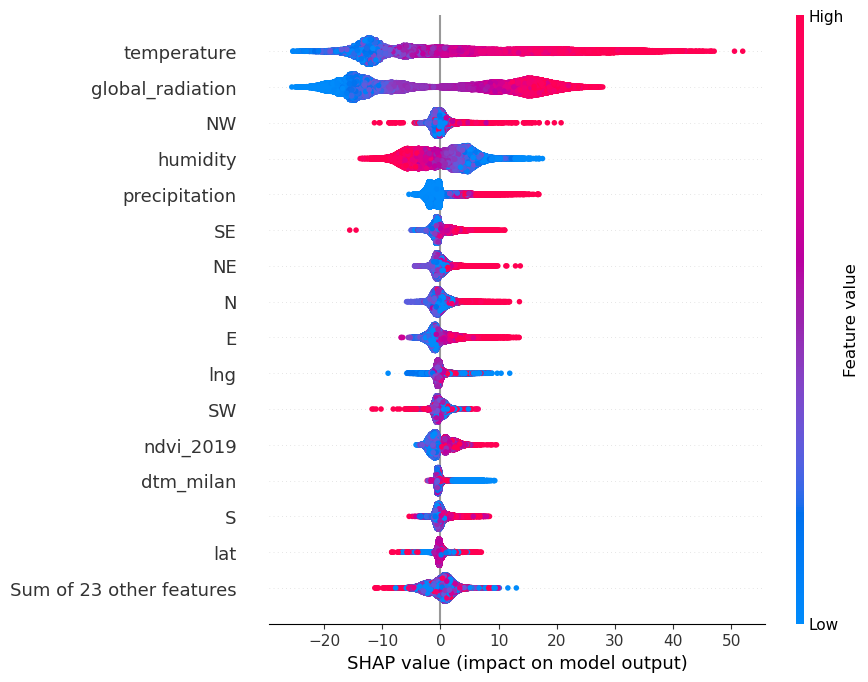

In [35]:
shap.plots.beeswarm(shap_values, max_display=16, order=shap_values.abs.max(0))

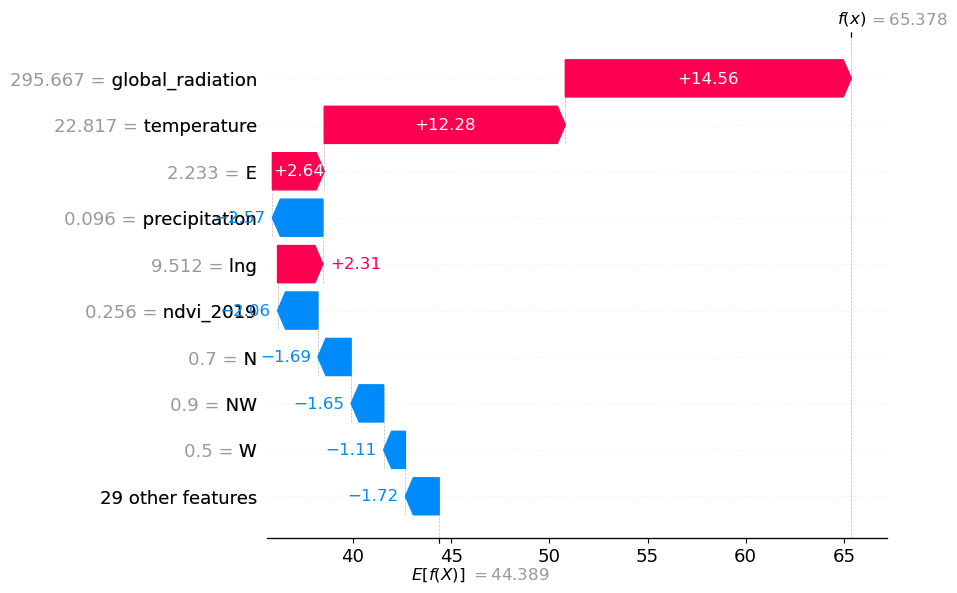

In [40]:
shap.plots.waterfall(shap_values[100])

In [8]:
#plot for model accuracies
#calculate best models
scores_path = f'../harmonia_processor/model_scores_regression.csv'
scores_df = importer.import_df(scores_path, date_format=None)
scores_df = scores_df.reset_index(drop=True)
metric_to_plot = 'MAE'
for model in models:
    plot_dfs = []
    plot_names = []
    sort_by = 'train_mode'
    print(f"--------------------------------------------------")
    print(f"scores for model {model}")
    for pollutant in pollutants:
        if (model != 'SVM' and pollutant != 'o3'):
            temp_plot_df = scores_df.loc[
                (scores_df['pollutant'] == pollutant) & (scores_df['type'] == model)
            ].reset_index(drop=True).sort_values(by=sort_by)
            plot_dfs.append(temp_plot_df.copy())
            plot_names.append(pollutant)

    importer.show_plot(
        plot_dfs,
        ['train_mode', 'train_mode', 'train_mode', 'train_mode'],
        [metric_to_plot, metric_to_plot, metric_to_plot, metric_to_plot],
        plot_names
    )

--------------------------------------------------
scores for model LSTM


--------------------------------------------------
scores for model RF


--------------------------------------------------
scores for model SVM


--------------------------------------------------
scores for model XGBoost


In [9]:
#calculate best models
scores_path = f'../harmonia_processor/model_scores_regression.csv'
scores_df = importer.import_df(scores_path, date_format=None)
scores_df = scores_df.reset_index(drop=True)

best_model_data = {}
for pollutant in pollutants:
    best = scores_df.sort_values(by='R2', ascending=False).loc[
        scores_df['pollutant'] == pollutant
    ].reset_index(drop=True).iloc[0]
    best_path = f'../harmonia_processor/{pollutant}/model/{best.prefix}_model_{best.train_mode}.csv'
    best_type = best.type
    best_model_data[pollutant] = {
        "model_path": best_path,
        "prefix": best.prefix,
        "train_mode": best.train_mode,
        "type": best_type,
        "score": best.R2
    }
best_model_data

{'pm10': {'model_path': '../harmonia_processor/pm10/model/rf_model_rand_NObalance.csv',
  'prefix': 'rf',
  'train_mode': 'rand_NObalance',
  'type': 'RF',
  'score': 0.7745361412818431},
 'pm25': {'model_path': '../harmonia_processor/pm25/model/rf_model_rand_NObalance.csv',
  'prefix': 'rf',
  'train_mode': 'rand_NObalance',
  'type': 'RF',
  'score': 0.786663881727911},
 'no2': {'model_path': '../harmonia_processor/no2/model/rf_model_rand_balance.csv',
  'prefix': 'rf',
  'train_mode': 'rand_balance',
  'type': 'RF',
  'score': 0.7700098049184723},
 'so2': {'model_path': '../harmonia_processor/so2/model/rf_model_rand_balance.csv',
  'prefix': 'rf',
  'train_mode': 'rand_balance',
  'type': 'RF',
  'score': 0.4958214117787308},
 'o3': {'model_path': '../harmonia_processor/o3/model/rf_model_rand_NObalance.csv',
  'prefix': 'rf',
  'train_mode': 'rand_NObalance',
  'type': 'RF',
  'score': 0.9295832707580246}}

In [21]:
#predict the stations and grid samples for each model, each month, each pollutant, for the best model score
best_base_path_predictions = f'../best_model/predictions'
#pollutants = ['pm10', 'pm25', 'no2']
pollutants = ['no2']
for pollutant in pollutants:
    print(f"FOR {pollutant}")
    pollutant_threshold = pollutant_data[pollutant]['threshold']
    model_data = best_model_data[pollutant]
    train_mode = model_data['train_mode']
    prefix = 'xgb' #model_data['prefix']
    model_to_use = model_data['type']
    print(f'Model to use: {model_to_use}')

    train_path = f'../harmonia_processor/{pollutant}/train/training_{train_mode}.csv'
    training_dataset = importer.import_df(train_path, date_format='%Y-%m-%d')
    training_dataset = training_dataset.dropna()
    training_dates = training_dataset.copy()[['date']]
    if 'date' in list(training_dataset.columns):
        training_dataset = training_dataset.drop(['date'], axis=1)
    #Update pollution thresholds to latest regulation (2030)
    training_dataset['exc'] = np.where(training_dataset[pollutant].gt(pollutant_threshold), 1, 0)

    test_path = f'../harmonia_processor/{pollutant}/train/validation_{train_mode}.csv'
    testing_dataset = importer.import_df(test_path, date_format='%Y-%m-%d')
    testing_dataset = testing_dataset.dropna()
    testing_dates = testing_dataset.copy()[['date']]
    if 'date' in list(testing_dataset.columns):
        testing_dataset = testing_dataset.drop(['date'], axis=1)
    #Update pollution thresholds to latest regulation (2030)
    testing_dataset['exc'] = np.where(testing_dataset[pollutant].gt(pollutant_threshold), 1, 0)

    #save the training columns for selecting them in the prediction dataset
    training_columns = list(training_dataset.columns)
    training_columns.remove('exc')
    #remove the measurement as well e.g., 'pm10'
    training_columns.remove(pollutant)


    ai_model = ai.AIProcessor(model_type=model_to_use, task_type='regression',hyperparameter_tuning=False)
    ai_model.set_data(partition=False, normalize=True, data={'train': training_dataset.copy(), 'test':testing_dataset.copy(),'training_columns': training_columns ,'target':pollutant})

   
    model_path = f'../harmonia_processor/{pollutant}/model/{prefix}_model_{train_mode}.csv'
    ai_model.load_model(model_path)

    predictions = {}
    predictions_grid = {}
    predicts = {}
    predicts_grid = {}

    for m in range(1,13):
        print(f'FOR {pollutant} MONTH {m}')
        print(f"Predicting in stations datasets")
        predict_path = f'../harmonia_processor/{pollutant}/predict/stations_month_{m}.csv'
        prediction_df =  importer.import_df(predict_path, date_format=None)
        prediction_dataset = prediction_df.copy()
        prediction_dataset = prediction_dataset[training_columns]
        predicts[m] = prediction_df.copy()
        if 'date' in list(prediction_dataset.columns):
            prediction_dataset = prediction_dataset.drop(['date'], axis=1)

        prediction_dataset = prediction_dataset.reset_index(drop=True).dropna()

        '''
        if model_to_use == 'lstm':
            predicted_probabilities = ai_model.predict(
                prediction_dataset.copy(), 
                predict_options=model_options[model_to_use]['prediction_options']
            )
        else:
            predicted_probabilities = ai_model.predict_probabilities(
                prediction_dataset.copy(),
                predict_options=model_options[model_to_use]['prediction_options']
            )
            predicted_probabilities = predicted_probabilities[:,1]
        '''

        predicted_probabilities = ai_model.predict(prediction_dataset.copy(), normalized=True)
        #Create a DF from predicted labels
        predicted_df = pd.DataFrame(predicted_probabilities)
        predicted_df.columns = [pollutant]

        #Concat DF with UTM coordinates 
        predicted_df = predicted_df.reset_index(drop=True)
        prediction_locations = prediction_dataset[['lat','lng']].reset_index(drop=True)
        predicted_df = pd.concat([predicted_df, prediction_locations],axis=1)

        predictions[m] = predicted_df.copy()

        prediction_path = f'{best_base_path_predictions}/best_{pollutant}_regression_stations_month_{m}.csv'
        predictions[m].to_csv(prediction_path)


        print(f"Predicting in grid datasets")
        predict_path = f'../harmonia_processor/{pollutant}/predict/grid_month_{m}.csv'
        prediction_df =  importer.import_df(predict_path, date_format=None)
        prediction_dataset = prediction_df.copy()
        prediction_dataset = prediction_dataset[training_columns]
        predicts_grid[m] = prediction_df.copy()
        if 'date' in list(prediction_dataset.columns):
            prediction_dataset = prediction_dataset.drop(['date'], axis=1)


        prediction_dataset = prediction_dataset.reset_index(drop=True).dropna()

        predicted_probabilities = ai_model.predict(prediction_dataset.copy(), normalized=True)
        
        #Create a DF from predicted labels
        predicted_df = pd.DataFrame(predicted_probabilities)
        predicted_df.columns = [pollutant]

        #Concat DF with UTM coordinates 
        #reset index to avoid indexing problems
        predicted_df = predicted_df.reset_index(drop=True)
        prediction_locations = prediction_dataset[['lat','lng']].reset_index(drop=True)
        predicted_df = pd.concat([predicted_df, prediction_locations],axis=1)

        predictions_grid[m] = predicted_df.copy()

        prediction_path = f'{best_base_path_predictions}/best_{pollutant}__regression_grid_month_{m}.csv'
        predictions_grid[m].to_csv(prediction_path)


FOR no2
Model to use: RF
FOR no2 MONTH 1
Predicting in stations datasets
Predicting in grid datasets
FOR no2 MONTH 2
Predicting in stations datasets
Predicting in grid datasets
FOR no2 MONTH 3
Predicting in stations datasets
Predicting in grid datasets
FOR no2 MONTH 4
Predicting in stations datasets
Predicting in grid datasets
FOR no2 MONTH 5
Predicting in stations datasets
Predicting in grid datasets
FOR no2 MONTH 6
Predicting in stations datasets
Predicting in grid datasets
FOR no2 MONTH 7
Predicting in stations datasets
Predicting in grid datasets
FOR no2 MONTH 8
Predicting in stations datasets
Predicting in grid datasets
FOR no2 MONTH 9
Predicting in stations datasets
Predicting in grid datasets
FOR no2 MONTH 10
Predicting in stations datasets
Predicting in grid datasets
FOR no2 MONTH 11
Predicting in stations datasets
Predicting in grid datasets
FOR no2 MONTH 12
Predicting in stations datasets
Predicting in grid datasets


In [11]:
predicted_probabilities

array([36.16283184, 45.47118478, 45.60810145, ..., 34.5117837 ,
       44.88644354, 58.5907337 ])

In [12]:
milano_shapefile = '../data/milano_final_shapefile/milano_metro.shp'
milano_epsg = 32632
grid = interp.create_grid_from_shapefile(milano_shapefile, xdelta=1000, ydelta=1000, shapefile_epsg=milano_epsg)


The grid of the shapefile


In [13]:
grid

centroids              original_centroids        lat  \
0     POINT (9.46843 45.57438)  POINT (536549.044 5046866.166)  45.574376   
1     POINT (9.45569 45.58343)  POINT (535549.044 5047866.166)  45.583428   
2     POINT (9.50696 45.58321)  POINT (539549.044 5047866.166)  45.583212   
3     POINT (9.49415 45.58327)  POINT (538549.044 5047866.166)  45.583268   
4     POINT (9.44287 45.58348)  POINT (534549.044 5047866.166)  45.583479   
...                        ...                             ...        ...   
1726  POINT (8.82804 45.43119)  POINT (486549.044 5030866.166)  45.431188   
1727  POINT (8.81526 45.43117)  POINT (485549.044 5030866.166)  45.431168   
1728  POINT (8.80247 45.43115)  POINT (484549.044 5030866.166)  45.431147   
1729  POINT (8.84083 45.43121)  POINT (487549.044 5030866.166)  45.431207   
1730  POINT (8.81523 45.44017)  POINT (485549.044 5031866.166)  45.440170   

           lng  
0     9.468434  
1     9.455691  
2     9.506964  
3     9.494145  
4     9.442873  
...        ...  
1726  8.828041  
1727  8.815257  
1728  8.802473  
1729  8.840825  
1730  8.815228  

[1731 rows x 4 columns]

In [16]:
prediction_m


no2       lat      lng
0   46.732089  45.17190  9.48900
1   34.803109  45.28196  8.98856
2   58.848642  45.32450  9.13450
3   49.177187  45.39470  8.88970
4   61.471469  45.39620  9.28270
5   56.679607  45.43610  9.09740
6   70.007560  45.44386  9.16794
7   44.226197  45.45810  8.85440
8   50.241113  45.46242  8.88021
9   63.599273  45.46335  9.19532
10  70.033043  45.47050  9.19746
11  71.540974  45.47170  9.18910
12  46.028044  45.47260  9.35350
13  59.421557  45.47320  9.22230
14  66.069052  45.47610  9.14180
15  57.578732  45.47900  9.23549
16  48.109774  45.48363  9.32736
17  78.532583  45.49010  9.19440
18  61.636086  45.49160  9.24870
19  80.534446  45.49630  9.19090
20  80.930029  45.49632  9.19093
21  64.533799  45.49680  9.25750
22  59.522666  45.51730  9.09160
23  62.167916  45.51780  9.08790
24  60.364964  45.52343  9.04460
25  57.130203  45.52647  9.51598
26  34.567046  45.52655  8.73650
27  71.635598  45.53477  9.23611
28  63.783735  45.53560  9.00520
29  72.837339  45.54270  9.20560
30  33.104306  45.54850  8.84730
31  33.079990  45.54852  8.84732
32  73.902833  45.55104  9.16261
33  75.326938  45.55233  9.22776
34  66.371661  45.58310  9.15770
35  33.251804  45.60780  8.95290
36  43.728411  45.61370  9.50810

------ no2 --- month 1 ------
Creating an interpolation with the Nearest Neighbour method
Plotting the results...


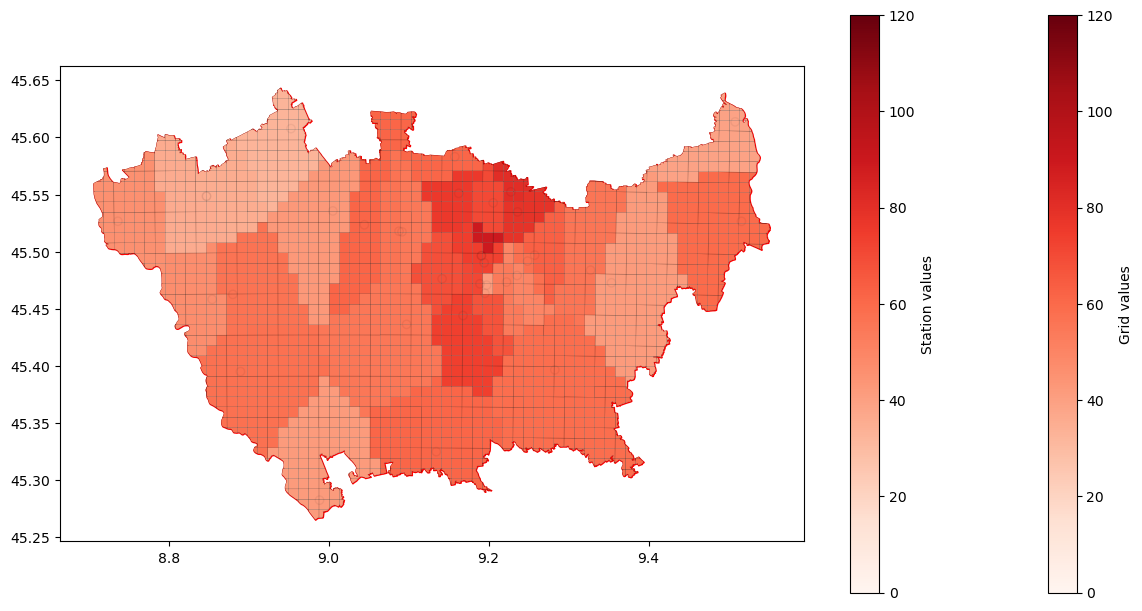

saved raster to ../best_model/rasters/regression_stations_no2_month_1.tiff
------ no2 --- month 2 ------
Creating an interpolation with the Nearest Neighbour method
Plotting the results...


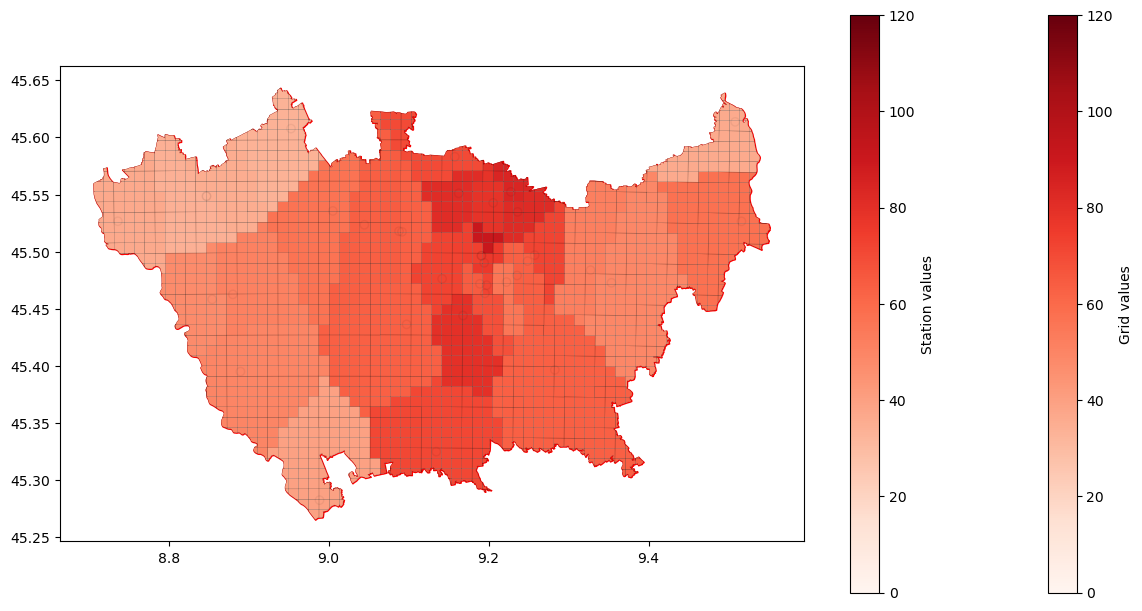

saved raster to ../best_model/rasters/regression_stations_no2_month_2.tiff
------ no2 --- month 3 ------
Creating an interpolation with the Nearest Neighbour method
Plotting the results...


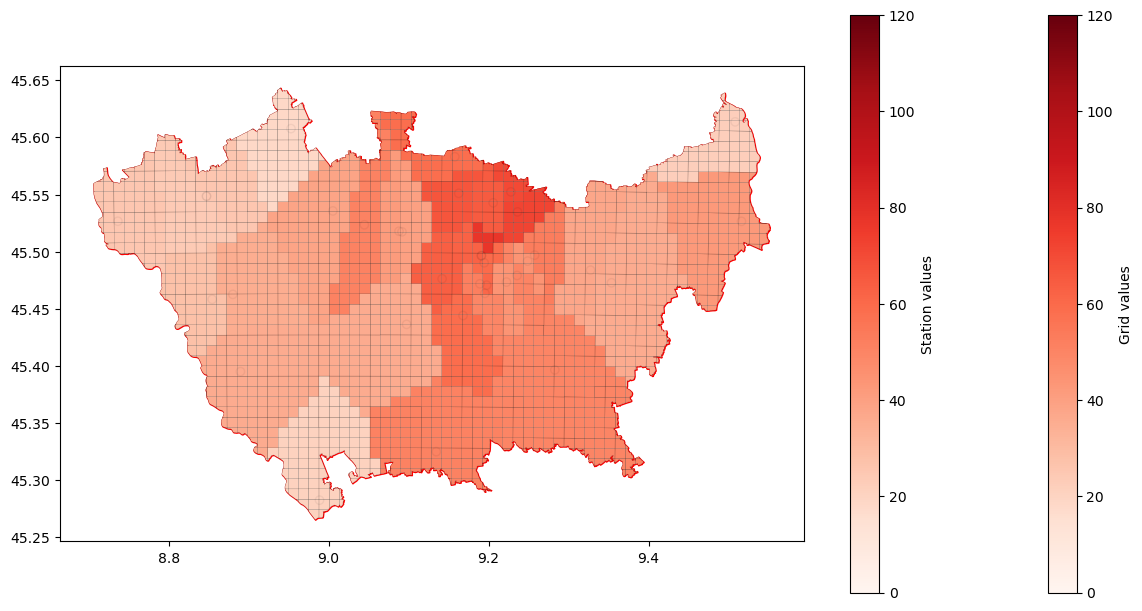

saved raster to ../best_model/rasters/regression_stations_no2_month_3.tiff
------ no2 --- month 4 ------
Creating an interpolation with the Nearest Neighbour method
Plotting the results...


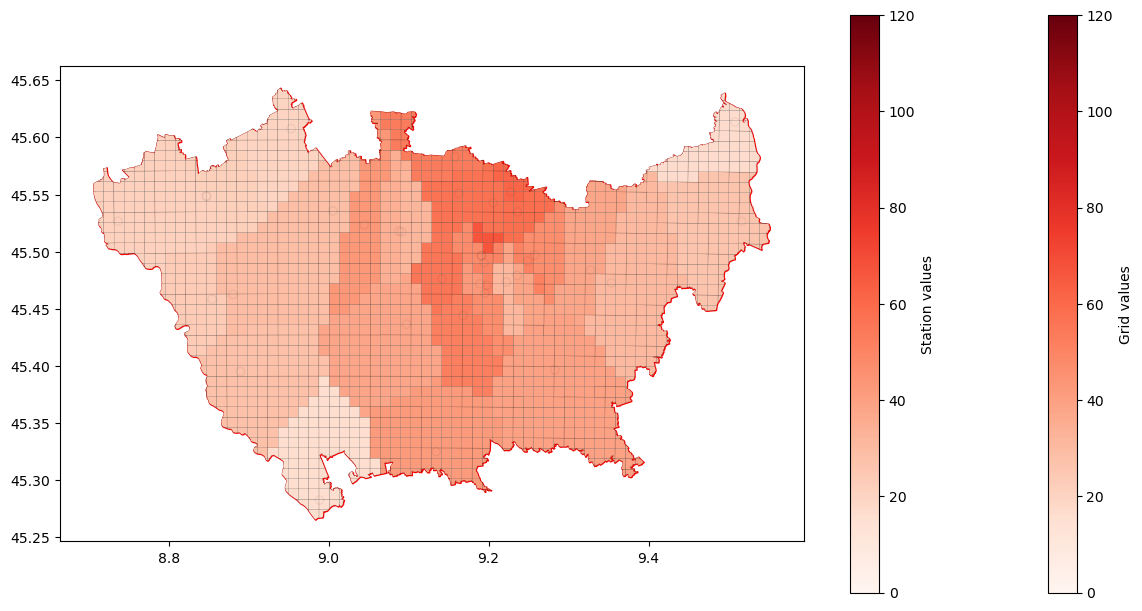

saved raster to ../best_model/rasters/regression_stations_no2_month_4.tiff
------ no2 --- month 5 ------
Creating an interpolation with the Nearest Neighbour method
Plotting the results...


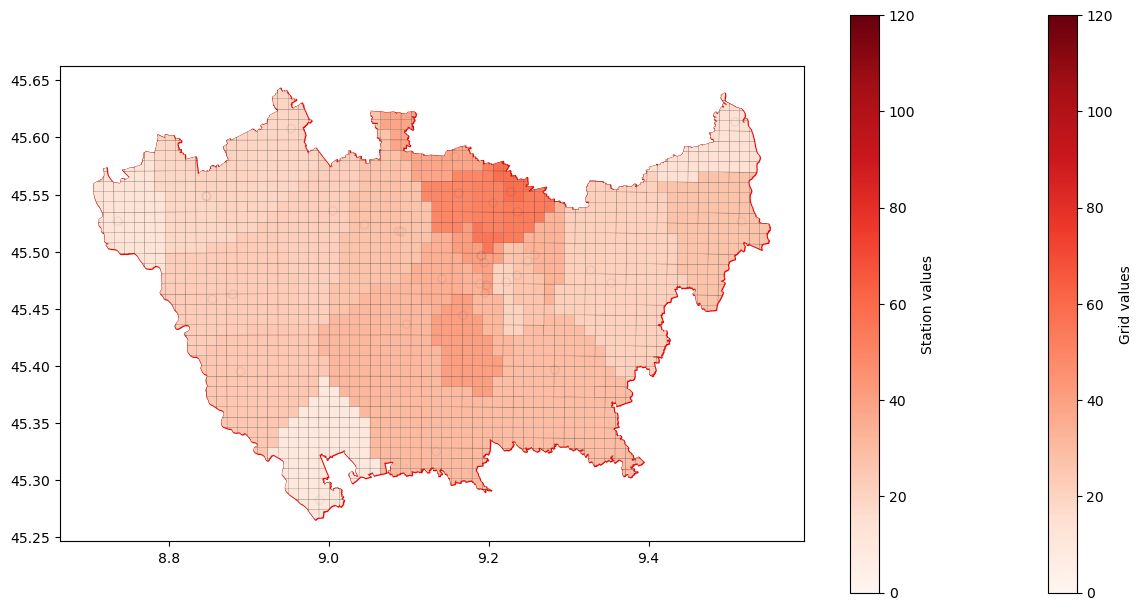

saved raster to ../best_model/rasters/regression_stations_no2_month_5.tiff
------ no2 --- month 6 ------
Creating an interpolation with the Nearest Neighbour method
Plotting the results...


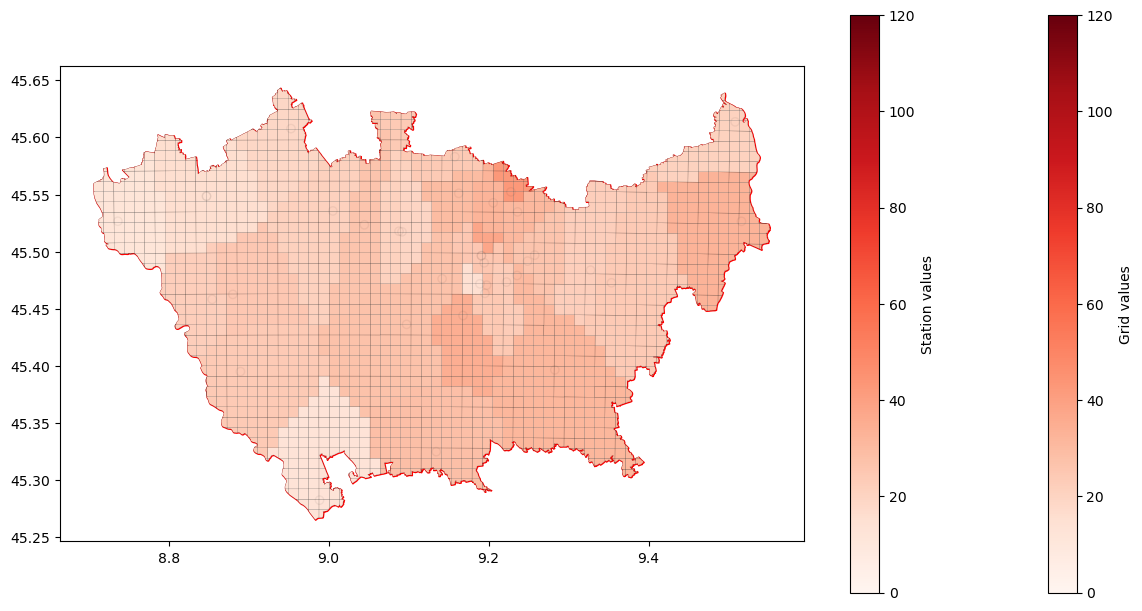

saved raster to ../best_model/rasters/regression_stations_no2_month_6.tiff
------ no2 --- month 7 ------
Creating an interpolation with the Nearest Neighbour method
Plotting the results...


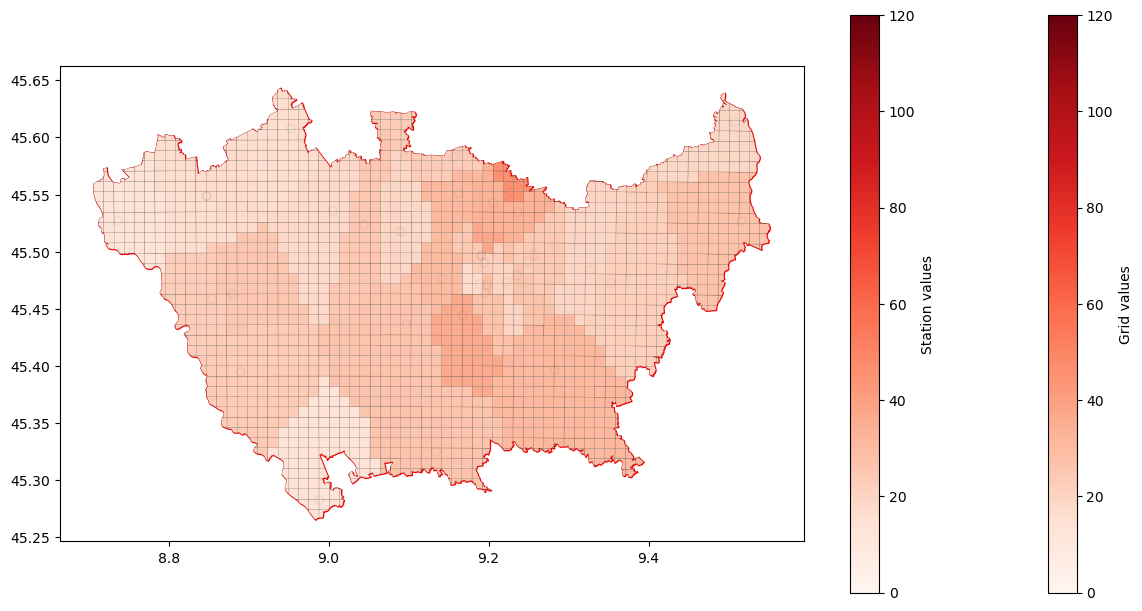

saved raster to ../best_model/rasters/regression_stations_no2_month_7.tiff
------ no2 --- month 8 ------
Creating an interpolation with the Nearest Neighbour method
Plotting the results...


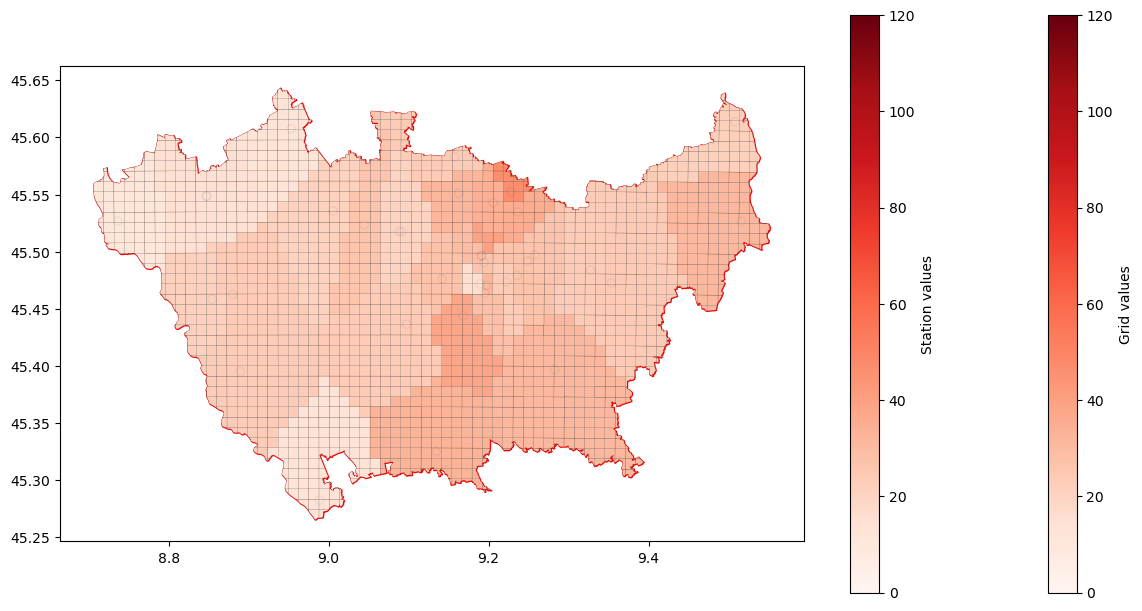

saved raster to ../best_model/rasters/regression_stations_no2_month_8.tiff
------ no2 --- month 9 ------
Creating an interpolation with the Nearest Neighbour method
Plotting the results...


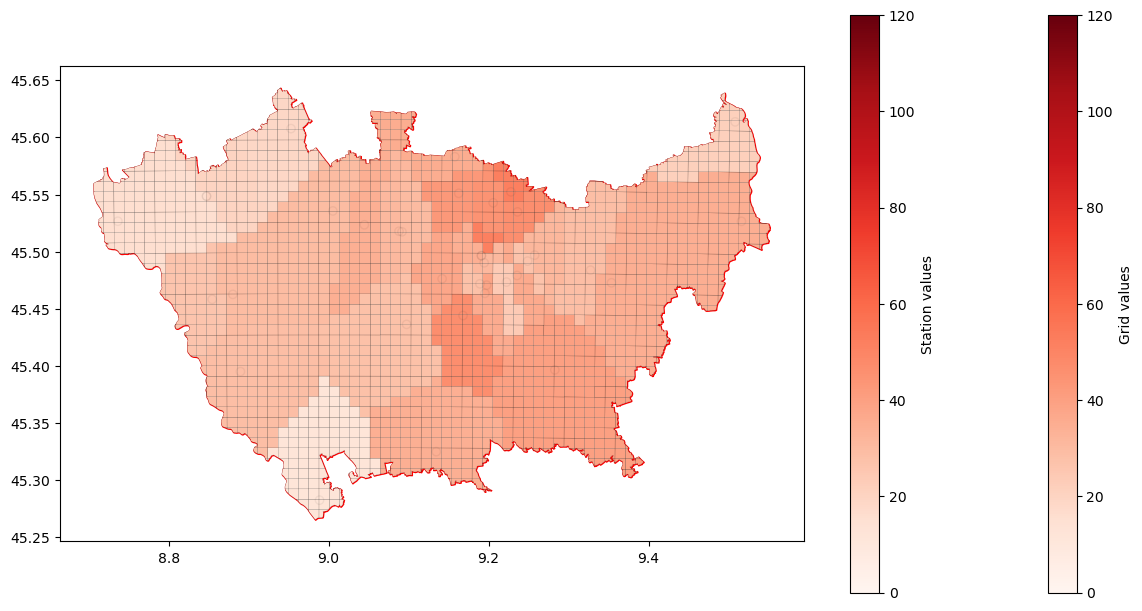

saved raster to ../best_model/rasters/regression_stations_no2_month_9.tiff
------ no2 --- month 10 ------
Creating an interpolation with the Nearest Neighbour method
Plotting the results...


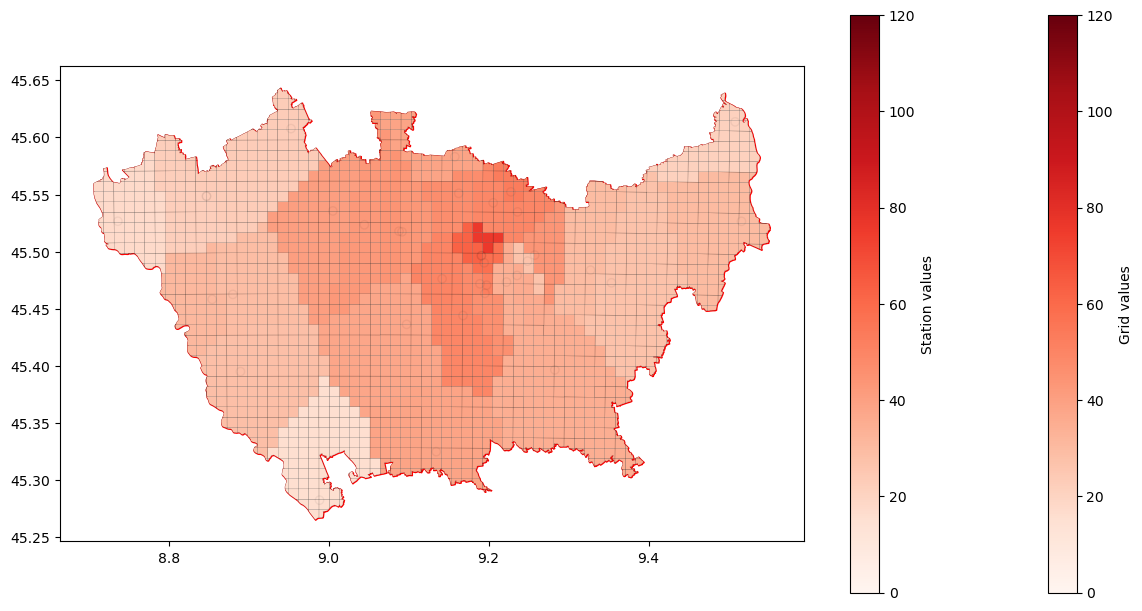

saved raster to ../best_model/rasters/regression_stations_no2_month_10.tiff
------ no2 --- month 11 ------
Creating an interpolation with the Nearest Neighbour method
Plotting the results...


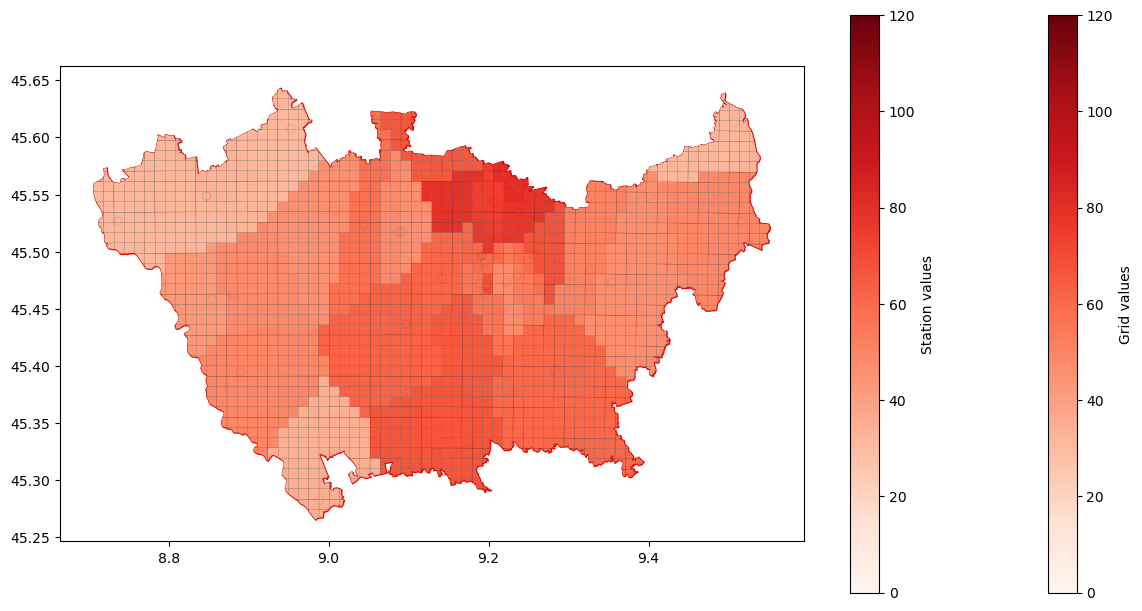

saved raster to ../best_model/rasters/regression_stations_no2_month_11.tiff
------ no2 --- month 12 ------
Creating an interpolation with the Nearest Neighbour method
Plotting the results...


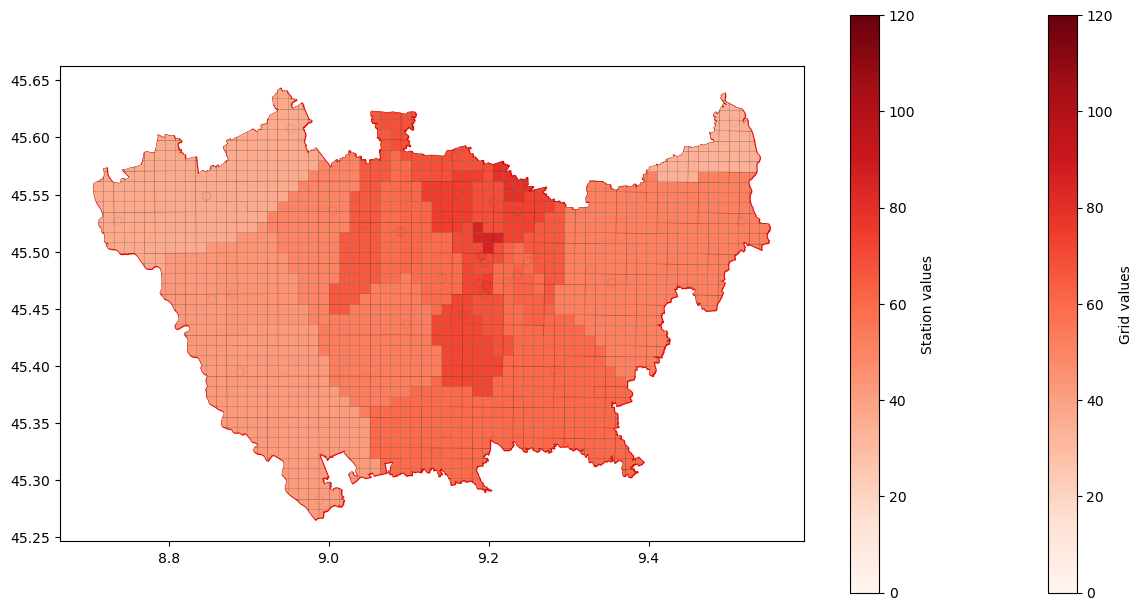

saved raster to ../best_model/rasters/regression_stations_no2_month_12.tiff


In [22]:
#Generate rasters with stations data
best_raster_base_path = f'../best_model/rasters'
for pollutant in pollutants:
    for m in range(1,13):
        prediction_path = f'{best_base_path_predictions}/best_{pollutant}_regression_stations_month_{m}.csv'
        prediction_m =  importer.import_df(prediction_path, date_format=None)
        print(f"------ {pollutant} --- month {m} ------")
        interpolated_to_grid,b = interp.interpolate(
            pollutant, 
            'NN', 
            milano_shapefile,
            prediction_m.copy(), 
            visual_output=True,
            epsg_utm=milano_epsg,
            plot_min=0,
            plot_max=120
        )

        new_interp = pd.DataFrame()
        new_interp['y'] = interpolated_to_grid.original_centroids.y
        new_interp['x'] = interpolated_to_grid.original_centroids.x
        new_interp['value'] = interpolated_to_grid.NN
        interp_xar = new_interp.set_index(['y', 'x']).to_xarray()

        raster_path = f'{best_raster_base_path}/regression_stations_{pollutant}_month_{m}.tiff'
        
        array_to_write = np.flip(np.flip(interp_xar.value.to_numpy()), axis=1)
        profile = {
            'driver': 'GTiff', 
            'dtype': 'float32', 
            'nodata': -9999.0, 
            'width': int(len(interp_xar.x)), 
            'height': int(len(interp_xar.y)), 
            'count': 1, 
            'crs': rio.CRS.from_epsg(32632), 
            'transform': rio.Affine(1000.0, 0.0, int(interp_xar.x[0]), 0.0, -1000.0, int(interp_xar.y[-1])), 
            'tiled': False, 
            'interleave': 'band'
        }
        with rio.open(raster_path, 'w', **profile) as dest:
            dest.write(array_to_write, 1)
    
        #prediction_raster = interp.save_as_raster(new_interp, raster_path, crs=milano_epsg)
        print(f"saved raster to {raster_path}")
    

------ no2 --- month 1 ------
Creating an interpolation with the Nearest Neighbour method
Plotting the results...


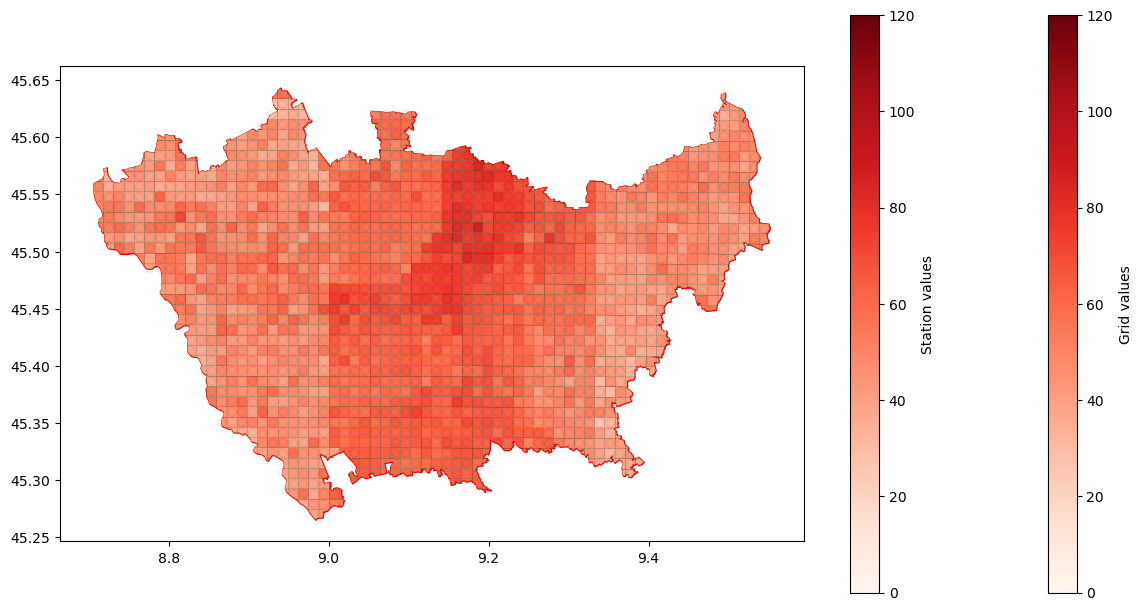

saved raster to ../best_model/rasters/regression_grid_no2_month_1.tiff
------ no2 --- month 2 ------
Creating an interpolation with the Nearest Neighbour method
Plotting the results...


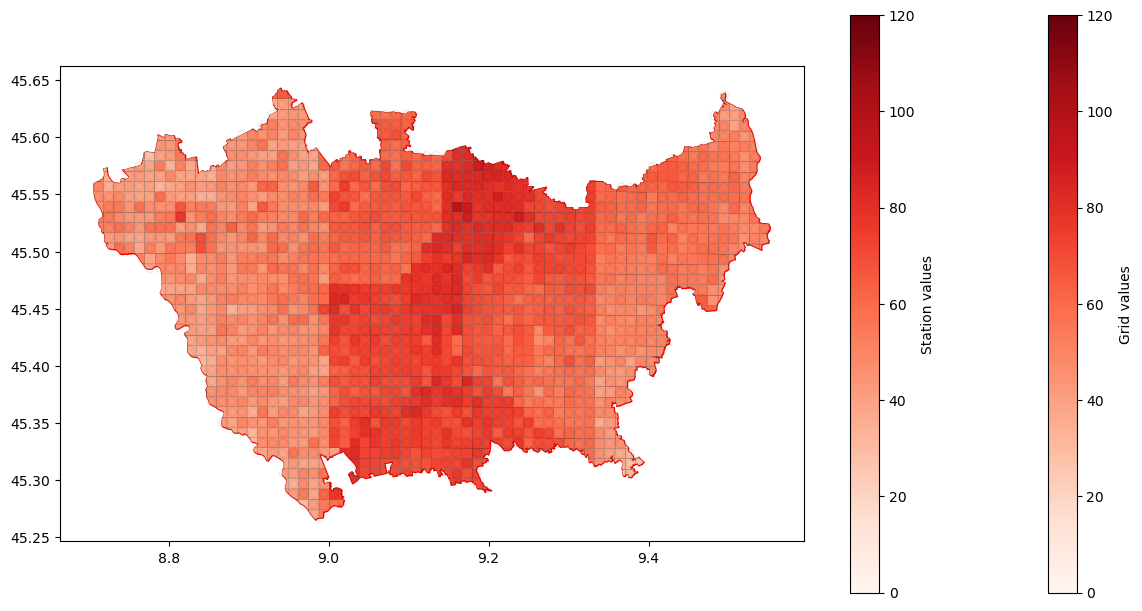

saved raster to ../best_model/rasters/regression_grid_no2_month_2.tiff
------ no2 --- month 3 ------
Creating an interpolation with the Nearest Neighbour method
Plotting the results...


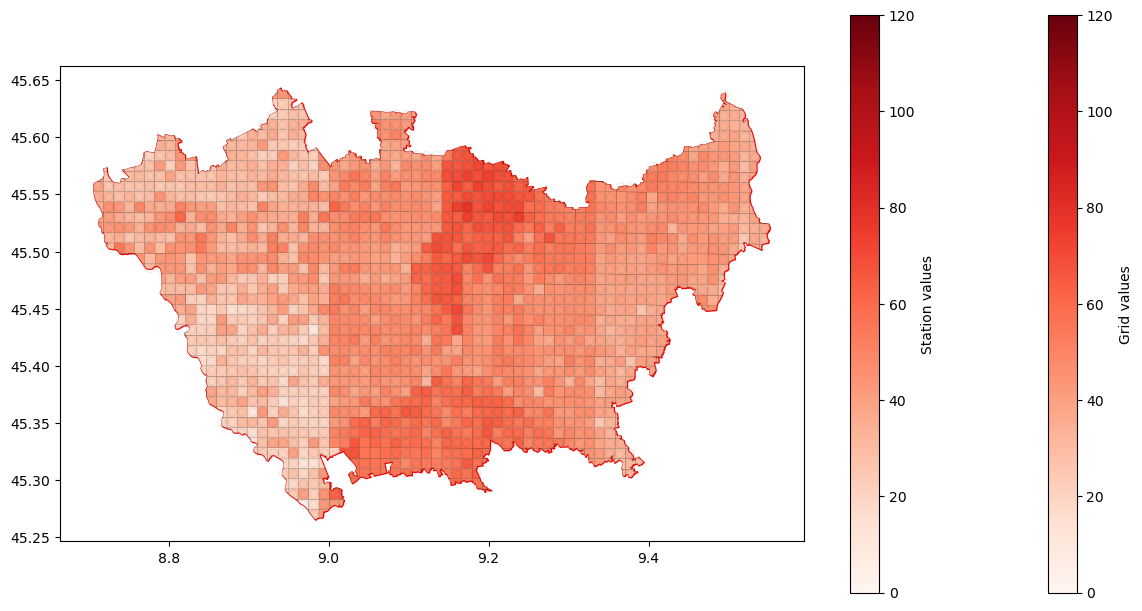

saved raster to ../best_model/rasters/regression_grid_no2_month_3.tiff
------ no2 --- month 4 ------
Creating an interpolation with the Nearest Neighbour method
Plotting the results...


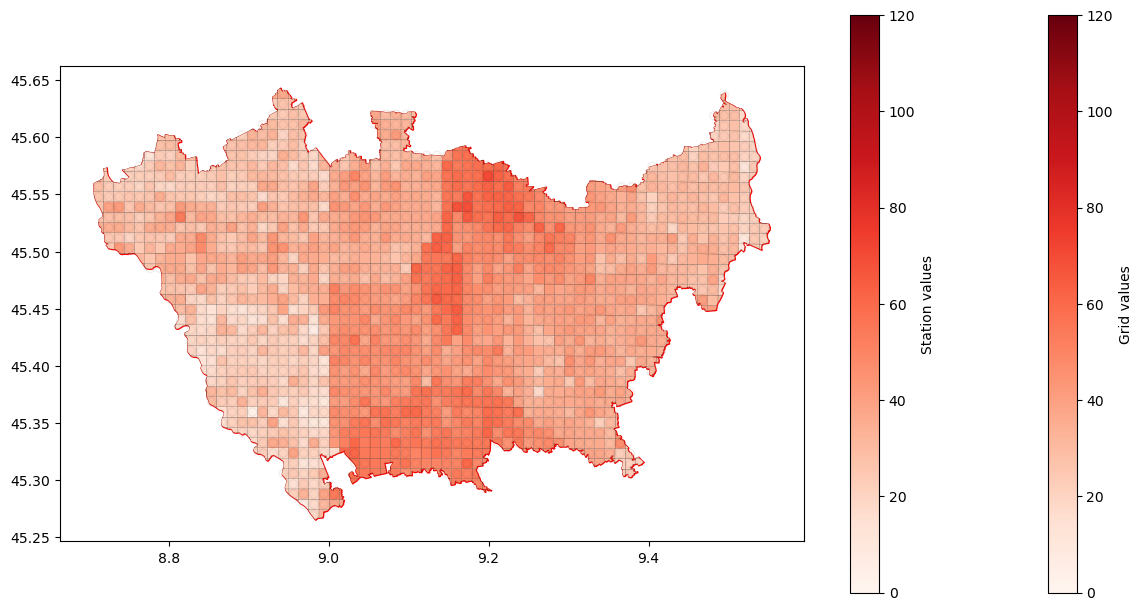

saved raster to ../best_model/rasters/regression_grid_no2_month_4.tiff
------ no2 --- month 5 ------
Creating an interpolation with the Nearest Neighbour method
Plotting the results...


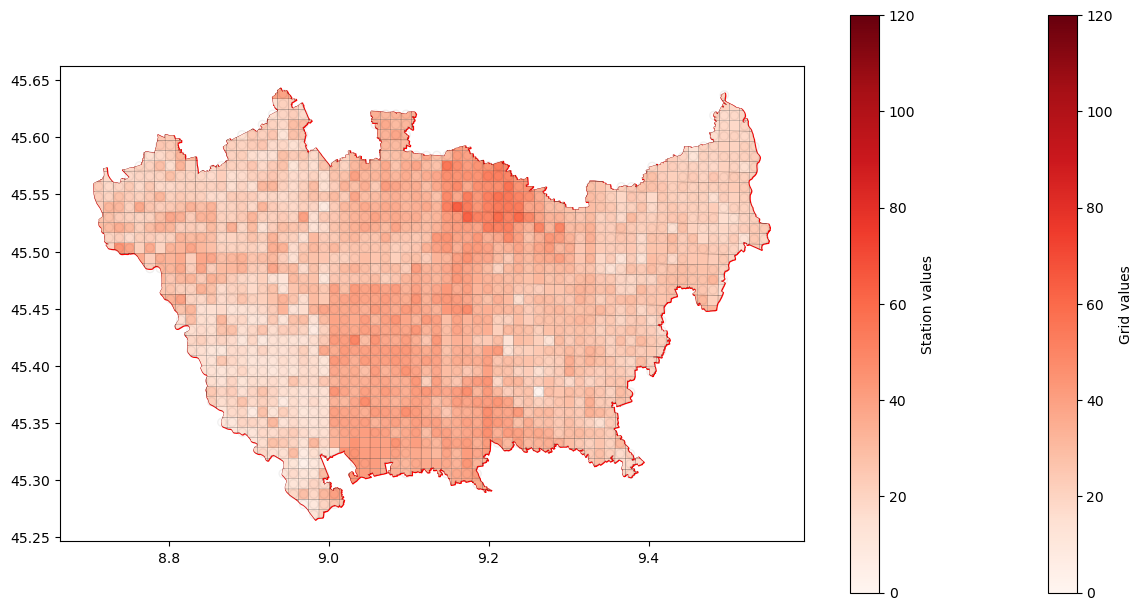

saved raster to ../best_model/rasters/regression_grid_no2_month_5.tiff
------ no2 --- month 6 ------
Creating an interpolation with the Nearest Neighbour method
Plotting the results...


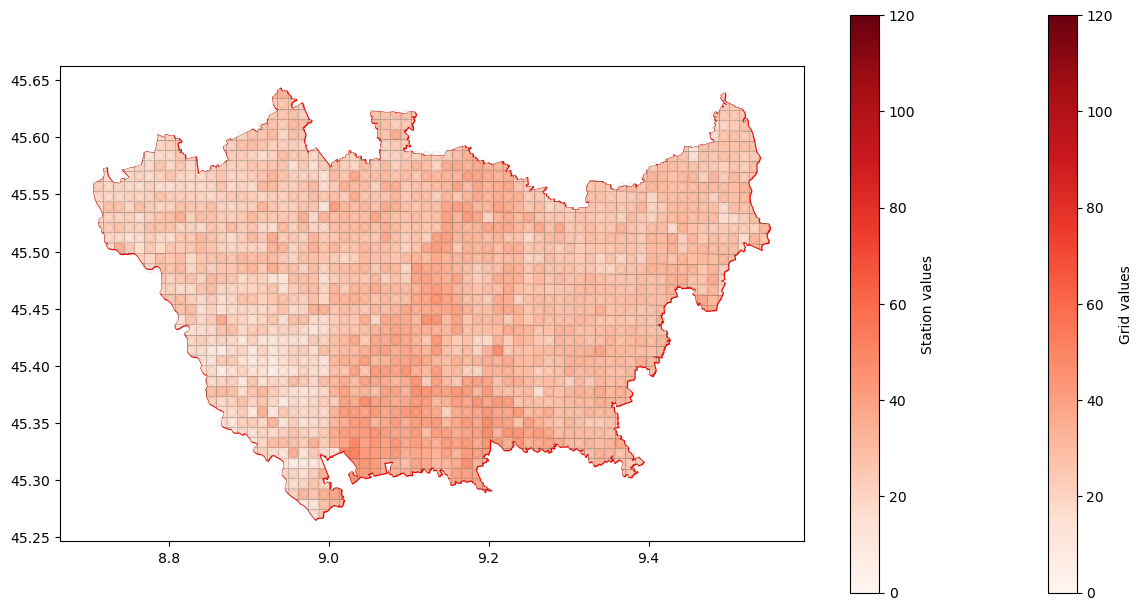

saved raster to ../best_model/rasters/regression_grid_no2_month_6.tiff
------ no2 --- month 7 ------
Creating an interpolation with the Nearest Neighbour method
Plotting the results...


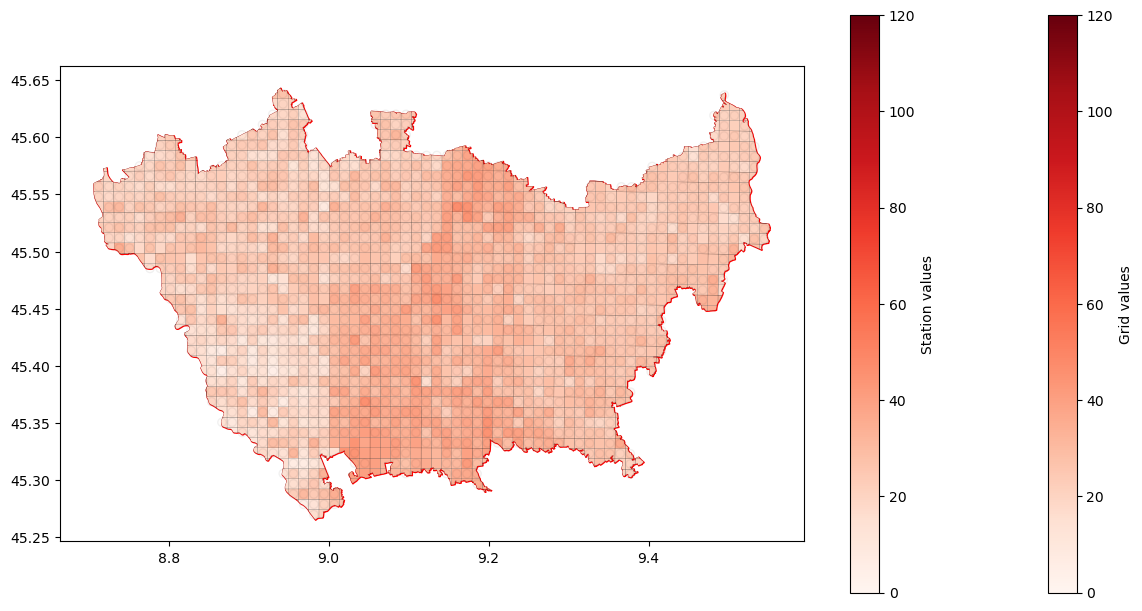

saved raster to ../best_model/rasters/regression_grid_no2_month_7.tiff
------ no2 --- month 8 ------
Creating an interpolation with the Nearest Neighbour method
Plotting the results...


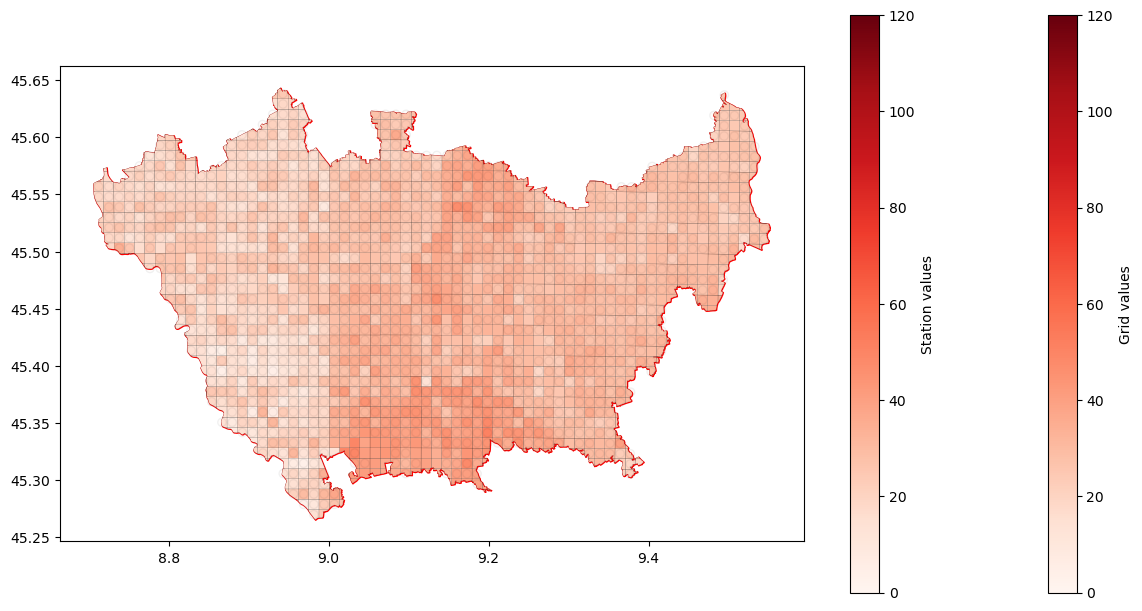

saved raster to ../best_model/rasters/regression_grid_no2_month_8.tiff
------ no2 --- month 9 ------
Creating an interpolation with the Nearest Neighbour method
Plotting the results...


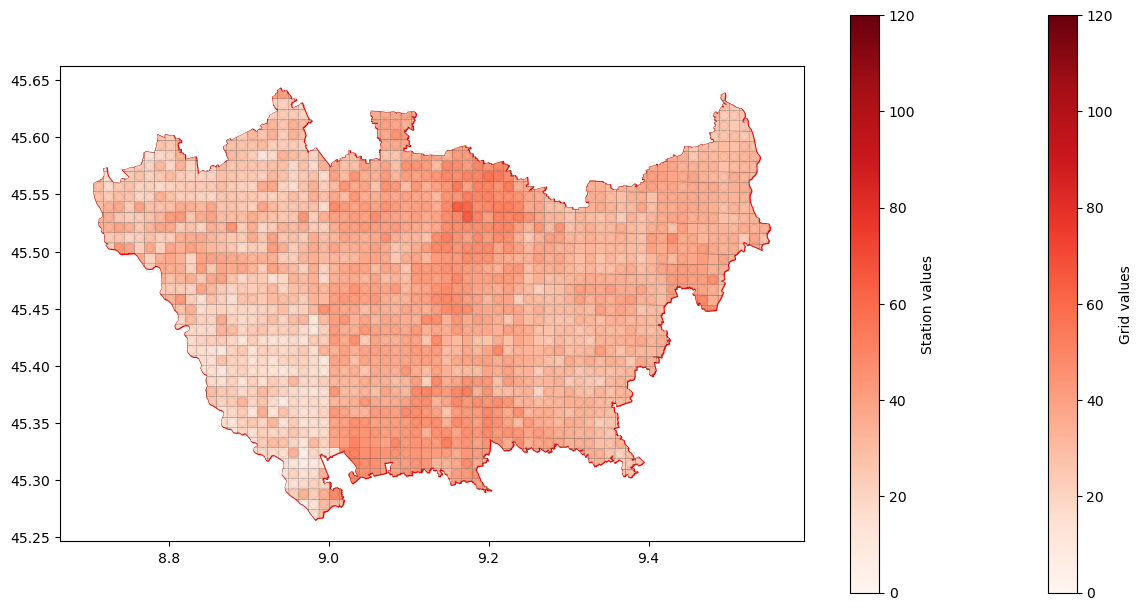

saved raster to ../best_model/rasters/regression_grid_no2_month_9.tiff
------ no2 --- month 10 ------
Creating an interpolation with the Nearest Neighbour method
Plotting the results...


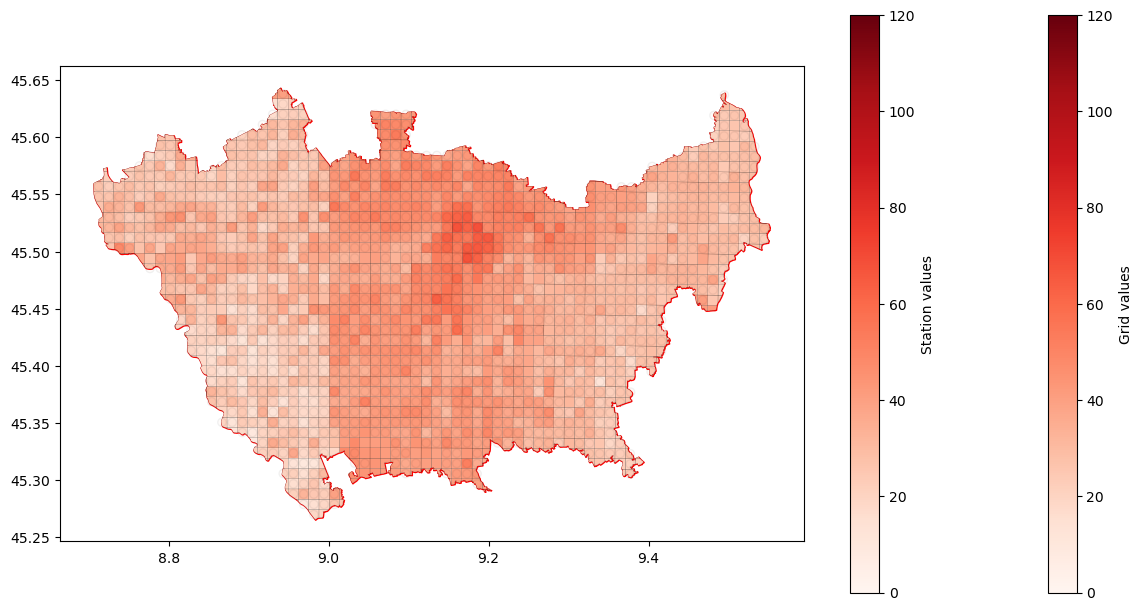

saved raster to ../best_model/rasters/regression_grid_no2_month_10.tiff
------ no2 --- month 11 ------
Creating an interpolation with the Nearest Neighbour method
Plotting the results...


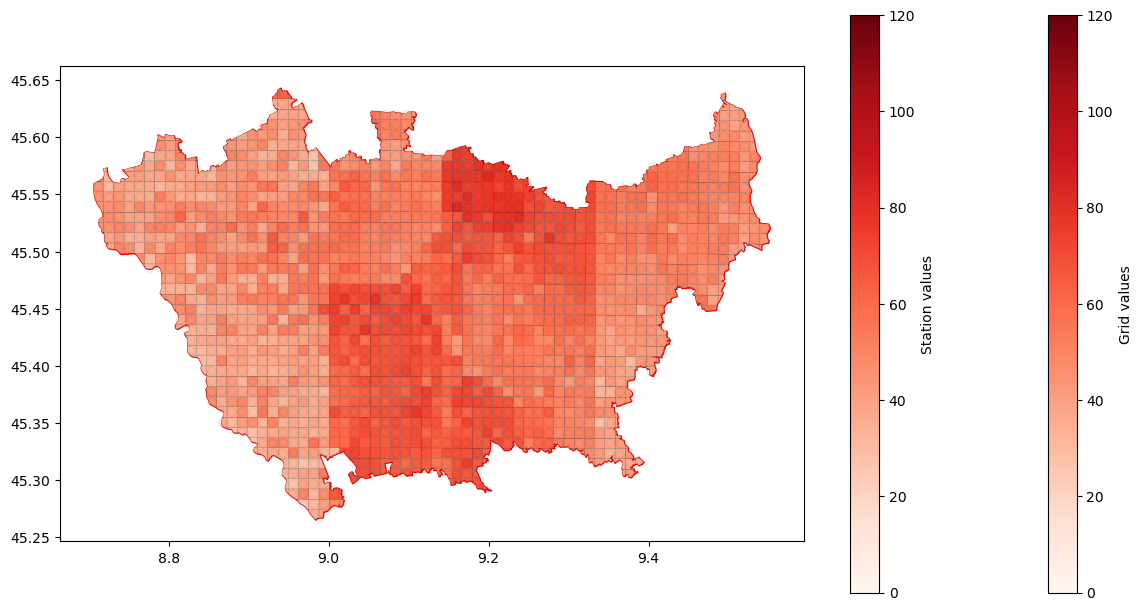

saved raster to ../best_model/rasters/regression_grid_no2_month_11.tiff
------ no2 --- month 12 ------
Creating an interpolation with the Nearest Neighbour method
Plotting the results...


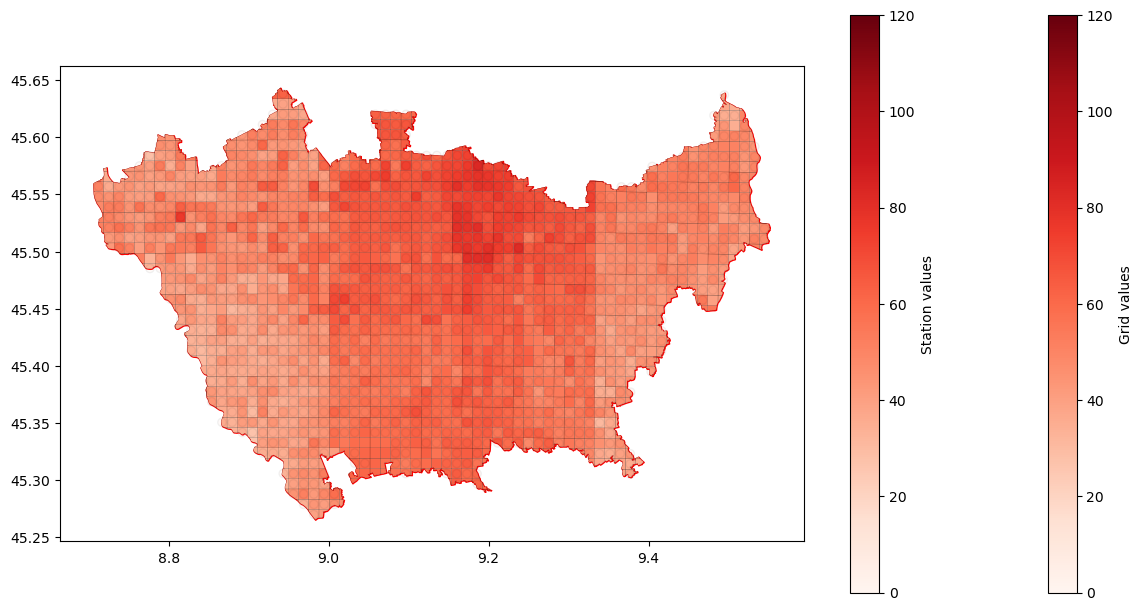

saved raster to ../best_model/rasters/regression_grid_no2_month_12.tiff


In [23]:
#Generate rasters with grid data
best_raster_base_path = f'../best_model/rasters'
for pollutant in pollutants:
    for m in range(1,13):
        prediction_path = f'{best_base_path_predictions}/best_{pollutant}__regression_grid_month_{m}.csv'
        prediction_m =  importer.import_df(prediction_path, date_format=None)
        print(f"------ {pollutant} --- month {m} ------")

        interpolated_to_grid,b = interp.interpolate(
            pollutant, 
            'NN', 
            milano_shapefile, 
            prediction_m, 
            visual_output=True,
            epsg_utm=milano_epsg,
            plot_min=0,
            plot_max=120
        )

        new_interp = pd.DataFrame()
        new_interp['y'] = interpolated_to_grid.original_centroids.y
        new_interp['x'] = interpolated_to_grid.original_centroids.x
        new_interp['value'] = interpolated_to_grid.NN
        
        interp_xar = new_interp.set_index(['y', 'x']).to_xarray()

        raster_path = f'{best_raster_base_path}/regression_grid_{pollutant}_month_{m}.tiff'
        
        array_to_write = np.flip(np.flip(interp_xar.value.to_numpy()), axis=1)
        profile = {
            'driver': 'GTiff', 
            'dtype': 'float32', 
            'nodata': -9999.0, 
            'width': int(len(interp_xar.x)), 
            'height': int(len(interp_xar.y)), 
            'count': 1, 
            'crs': rio.CRS.from_epsg(32632), 
            'transform': rio.Affine(1000.0, 0.0, int(interp_xar.x[0]), 0.0, -1000.0, int(interp_xar.y[-1])), 
            'tiled': False, 
            'interleave': 'band'
        }
        with rio.open(raster_path, 'w', **profile) as dest:
            dest.write(array_to_write, 1)

        
        #prediction_raster = interp.save_as_raster(new_interp, raster_path, crs=milano_epsg)
        print(f"saved raster to {raster_path}")
    

In [ ]:
#PREDICT ALL!
best_base_path_predictions = f'../harmonia_processor'
for pollutant in pollutants:
    print(f"FOR {pollutant}")
    for model_to_use in models:
        print(f"FOR {model_to_use}")
        for train_mode in train_modes:
            print(f"FOR {train_mode}")
            prefix = model_options[model_to_use]['prefix']

            train_path = f'{best_base_path_predictions}/{pollutant}/train/training_{train_mode}.csv'
            training_dataset = importer.import_df(train_path, date_format='%Y-%m-%d')
            training_dataset = training_dataset.dropna()
            training_dates = training_dataset.copy()[['date']]
            if 'date' in list(training_dataset.columns):
                training_dataset = training_dataset.drop(['date'], axis=1)

            test_path = f'{best_base_path_predictions}/{pollutant}/train/validation_{train_mode}.csv'
            testing_dataset = importer.import_df(test_path, date_format='%Y-%m-%d')
            testing_dataset = testing_dataset.dropna()
            testing_dates = testing_dataset.copy()[['date']]
            if 'date' in list(testing_dataset.columns):
                testing_dataset = testing_dataset.drop(['date'], axis=1)

            #save the training columns for selecting them in the prediction dataset
            training_columns = list(training_dataset.columns)
            if 'exc' in training_columns:
                training_columns.remove('exc')

            model_path = f'{best_base_path_predictions}/{pollutant}/model/{prefix}_model_{train_mode}.csv'
            ai_model = ai.MLProcessor(training_dataset.copy(), testing_dataset.copy())
            ai_model.load_model(model_path)
            ai_model.model_type = model_to_use

            predictions = {}
            predictions_grid = {}
            predicts = {}
            predicts_grid = {}

            for m in range(1,13):
                print(f'FOR {pollutant} MONTH {m}')
                print(f"Predicting in stations datasets")
                predict_path = f'{best_base_path_predictions}/{pollutant}/predict/stations_month_{m}.csv'
                prediction_df =  importer.import_df(predict_path, date_format=None)
                prediction_dataset = prediction_df.copy()
                prediction_dataset = prediction_dataset[training_columns]
                predicts[m] = prediction_df.copy()
                if 'date' in list(prediction_dataset.columns):
                    prediction_dataset = prediction_dataset.drop(['date'], axis=1)

                prediction_dataset = prediction_dataset.reset_index(drop=True).dropna()
                if model_to_use == 'lstm':
                    predicted_probabilities = ai_model.predict(
                        prediction_dataset.copy(), 
                        predict_options=model_options[model_to_use]['prediction_options']
                    )
                else:
                    predicted_probabilities = ai_model.predict_probabilities(
                        prediction_dataset.copy(),
                        predict_options=model_options[model_to_use]['prediction_options']
                    )
                    predicted_probabilities = predicted_probabilities[:,1]

                #Create a DF from predicted labels
                predicted_df = pd.DataFrame(predicted_probabilities)
                predicted_df.columns = ['exc']

                #Concat DF with UTM coordinates 
                predicted_df = predicted_df.reset_index(drop=True)
                prediction_locations = prediction_dataset[['lat','lng']].reset_index(drop=True)
                predicted_df = pd.concat([predicted_df, prediction_locations],axis=1)
                predicted_df['exc'] = predicted_df['exc']*100

                predictions[m] = predicted_df.copy()

                prediction_path = f'{best_base_path_predictions}/{pollutant}/predictions/{prefix}_prediction_month_{m}_stations_{train_mode}.csv'
                predictions[m].to_csv(prediction_path)


                print(f"Predicting in grid datasets")
                predict_path = f'{best_base_path_predictions}/{pollutant}/predict/grid_month_{m}.csv'
                prediction_df =  importer.import_df(predict_path, date_format=None)
                prediction_dataset = prediction_df.copy()
                prediction_dataset = prediction_dataset[training_columns]
                predicts_grid[m] = prediction_df.copy()
                if 'date' in list(prediction_dataset.columns):
                    prediction_dataset = prediction_dataset.drop(['date'], axis=1)


                prediction_dataset = prediction_dataset.reset_index(drop=True).dropna()
                if model_to_use == 'lstm':
                    predicted_probabilities = ai_model.predict(
                        prediction_dataset.copy(), 
                        predict_options=model_options[model_to_use]['prediction_options']
                    )
                else:
                    predicted_probabilities = ai_model.predict_probabilities(
                        prediction_dataset.copy(), 
                        predict_options=model_options[model_to_use]['prediction_options']
                    )
                    predicted_probabilities = predicted_probabilities[:,1]

                #Create a DF from predicted labels
                predicted_df = pd.DataFrame(predicted_probabilities)
                predicted_df.columns = ['exc']

                #Concat DF with UTM coordinates 
                #reset index to avoid indexing problems
                predicted_df = predicted_df.reset_index(drop=True)
                prediction_locations = prediction_dataset[['lat','lng']].reset_index(drop=True)
                predicted_df = pd.concat([predicted_df, prediction_locations],axis=1)
                predicted_df['exc'] = predicted_df['exc']*100

                predictions_grid[m] = predicted_df.copy()

                prediction_path = f'{best_base_path_predictions}/{pollutant}/predictions/{prefix}_prediction_month_{m}_grid_{train_mode}.csv'
                predictions_grid[m].to_csv(prediction_path)
